<div style="text-align: right">Cianna Calia</div>
<div style="text-align: right">BIMM 143, Winter 2021</div>

# Analyzing Structural Variability and Sequence Entropy in Streptopain
## BIMM 143 Project 3

### Scientific Question

To what degree does sequence variability correlate with structural variability in the C-terminal loop of streptopain, a protein in which this flexible region is believed to play a functional role?

### Background

Streptopain, or SpeB, a cysteine protease found in most strains of *Streptococcus pyogenes* with known contributions to disease caused by this pathogen, has a flexible C-terminal loop (1). While it may seem intuitive to expect that regions of a protein with less structural constraint might have less constraint on the amino acid sequence as well, structurally variable regions of proteins can actually play important functional roles, sometimes requiring their flexibility (2). This is the case for streptopain, the glycine-rich C-terminal latency loop of which has been experimentally shown to be both flexible and functionally significant, with proposed roles in activation, substrate specificity, and product release, based on both structural and mutational data (1, 2, 3, 4, 5).

<img src="2jtc_1_model.png" width="400">

**Figure 1.** Structure of mature C47S streptopain, PDB 2JTC model 1 (3). Residues of the flexible C-terminal loop (R223-N242), between β9 and β10, are shown in green (4); catalytic residues (H195 and C47S) are shown in red (3). Image created using UCSF Chimera (6).

### Scientific Hypothesis

In the flexible C-terminal loop of the cysteine protease streptopain, structural variability, as indicated by backbone RMSF values by residue using NMR solution structure PDB 2JCT, will not correlate with sequence variability, as measured by Shannon entropy values by residue. Specifically, I hypothesize that the RMSF values will be high throughout this region while at least some positions within the loop will have low sequence entropy.

## Code

The code below installs three R packages - bio3d, rentrez, and comprehenr:

In [ ]:
install.packages(c("bio3d", "rentrez", "comprehenr")) #(7, 8, 20)

The next block loads those packages, as well as the graphing package ggplot2:

In [239]:
library(bio3d)
library(rentrez)
library(comprehenr)
library(ggplot2)

bio3d, a package with many useful functions for manipulating sequences and structures, will be used mainly for the sequence alignment, the Shannon entropy calculation, and the RMSF calculation. rentrez will be used to fetch streptopain sequences with an Entrez search. comprehenr will be used for list comprehension.

### Part 1: Sequence Entropy

The next block carries out an Entrez search to obtain IDs of relevant database entries, using as search terms "Streptopain" or the enzyme's other name, "SpeB", in the title field. Searching specifically in the title is important to avoid extraneous results. It returns up to 250 IDs, using a web history object because of the large number of hits:

In [319]:
#(9)
prot_ids <- entrez_search(db = "protein", term = "SpeB[TITL] OR Streptopain[TITL]", retmax = 250, use_history=TRUE)

The code below fetches the sequences corresponding to the hits obtained and writes them to a file, prot_seqs.fasta:

In [320]:
#(9)
prot_seqs <- entrez_fetch(db = "protein", web_history = prot_ids$web_history, rettype = "fasta", retmax = 250)
cat(prot_seqs, file = "prot_seqs.fasta")

The next block reads those sequences out of the file prot_seqs.fasta, using bio3d's read.fasta function:

In [321]:
#(10)
seqs_from_fasta_file <- read.fasta("prot_seqs.fasta")
length(seqs_from_fasta_file$id) #Print number of sequences obtained to check

[1] 250

Since the structure used in Part 2 may or may not be among the first 250 hits, the code below checks if it is and adds it if it isn't:

In [322]:
if (!("pdb|2JTC|A" %in% seqs_from_fasta_file$id)) { #(26)
    seq_2jtc <- entrez_fetch(db = "protein", id = "pdb|2JTC|A", rettype = "fasta") #(9)
    cat(seq_2jtc, file = "prot_seqs.fasta", append=TRUE)
    seqs_from_fasta_file <- read.fasta("prot_seqs.fasta") #(10)
    print("PDB 2JTC has been added to the hits.")
} else {
    print("PDB 2JTC is already among the hits.")
}

[1] "PDB 2JTC is already among the hits."


Then the code below performs a multiple sequence alignment using the MUSCLE algorithm (11, 12, 13) with bio3d's seqaln function:

In [323]:
#(14)
alignment <- seqaln(seqs_from_fasta_file, id=NULL, profile=NULL, exefile="/Users/ciannac/Downloads/muscle3.8.31_i86darwin32", outfile="alignment.fa", protein=TRUE, seqgroup=FALSE, refine=FALSE)

Then the following code fetches the alignment row corresponding to the structure used in Part 2, PDB 2JTC:

In [324]:
ref_seq_ali <- alignment$ali[alignment$id == "pdb|2JTC|A",]

The block below calculates Shannon entropy for the MSA using bio3d's entropy function, and then makes a simple bar plot of the raw values:

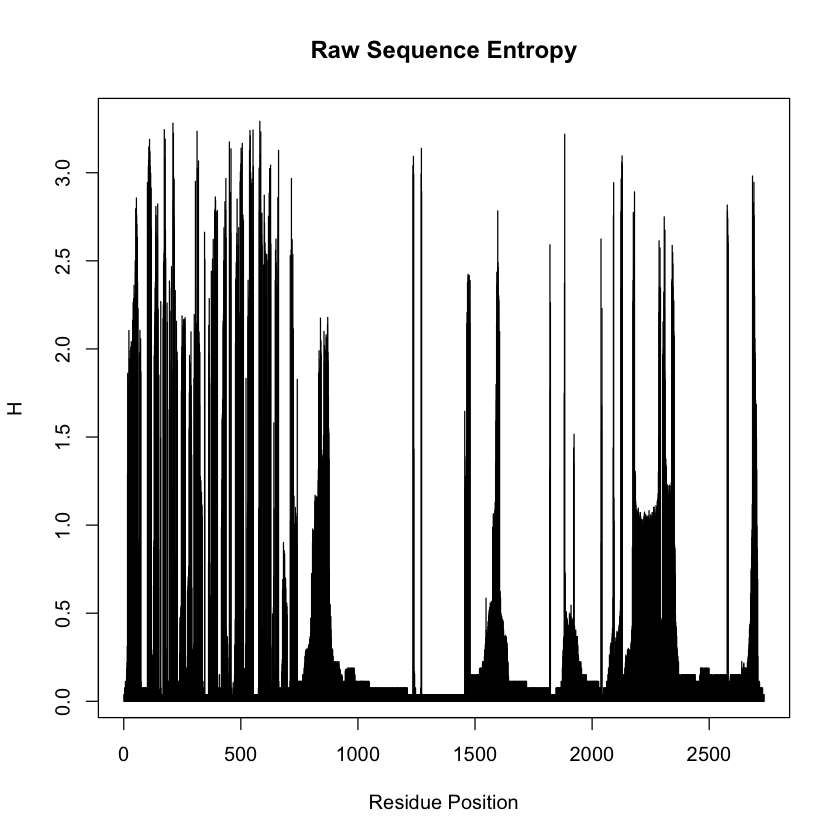

In [325]:
seqs_H <- entropy(alignment) #Calculate entropy (15).

plot(seqs_H$H, typ = "h", main = "Raw Sequence Entropy", xlab = "Residue Position", ylab = "H") #Plot results (16).

**Figure 2.** Shannon entropy by residue using the multiple sequence alignment, showing all positions of the alignment. The values are not normalized.

The next step is to select the alignment positions that correspond to the residues of the structure used for Part 2 and can therefore be used for a comparison to structural variability. The following code gets the indices in the relevant alignment row that are not gaps, using the to_vec function from comprehenr:

In [326]:
non_gap_indices <- to_vec(for (i in 1:length(ref_seq_ali)) if (!(ref_seq_ali[[i]] == '-')) i) #(19)

Then the code below takes the entropy values with those selected indices and normalizes them to a scale from 0 to 1:

In [327]:
normalize <- function(data_vec) {
    norm_vec <- to_vec(for (val in data_vec) if (val == val) ((val - min(data_vec)) / (max(data_vec) - min(data_vec)))) #(19)
    return(norm_vec)
} #(21) Define the normalize function.

#Use the function defined above to normalize selected values from seqs_H$H.
seqs_H_norm <- normalize(seqs_H$H[non_gap_indices])

Then the following code creates a vector containing a string for each residue index (in the reference sequence for PDB 2JTC) - "Loop" if it's in the C-terminal loop, "Catalytic" if it's a catalytic residue, and "Neither" otherwise. Then this vector is combined with a vector of the residue indices and the normalized entropy values into a dataframe:

In [328]:
res_type <- to_vec(for(i in 1:253) if(i >= 223 && i <= 242) "Loop" else if (i == 47 | i == 195) "Catalytic" else "Neither") #(3, 4, 19)
    
seq_df <- data.frame(res_type, res_inds = c(1:253), seqs_H_norm)

Then the code below plots the results:

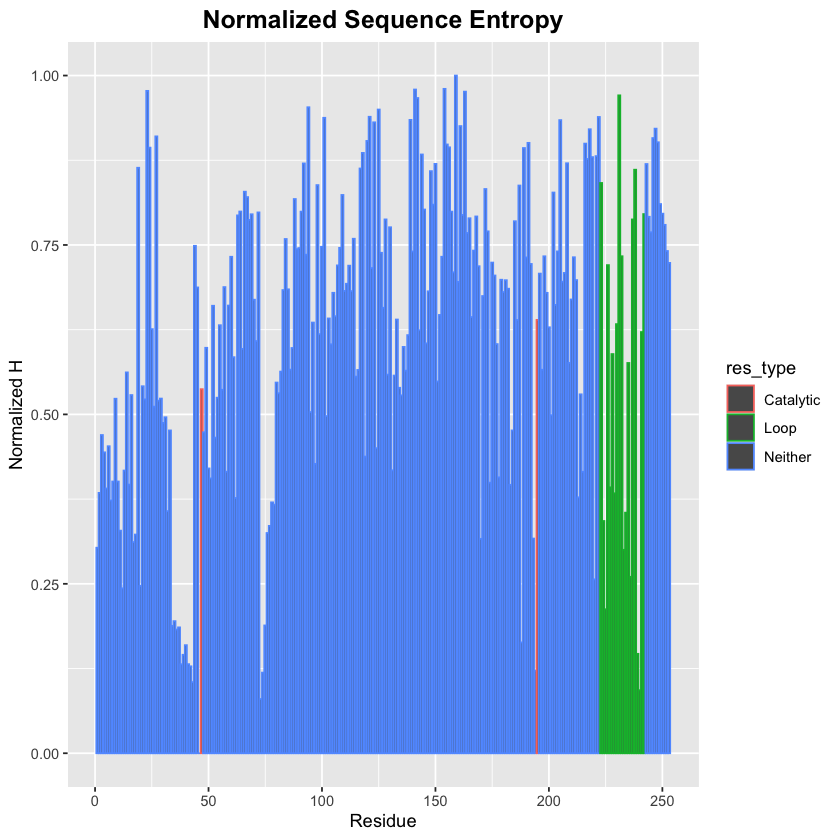

In [329]:
ggplot(seq_df, aes(x = res_inds, y = seqs_H_norm, color = res_type)) + geom_bar(stat="identity") + labs(title="Normalized Sequence Entropy", x ="Residue", y = "Normalized H") + theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5)) #(24, 25)

**Figure 3.** Shannon entropy by residue, normalized to a scale from 0 to 1, using only the positions of the multiple sequence alignment that correspond to the residues of the mature streptopain structure PDB 2JTC. The residues of the C-terminal loop are indicated with green bars; catalytic residues have red bars and all other residues are indicated with blue bars.

### Part 2: Structural Variability

The block below uses bio3d's read.pdb function to fetch the NMR solution structure of mature streptopain (3):

In [334]:
#(17)
struc_2jtc <- read.pdb("2jtc", multi = TRUE) #multi is TRUE because it's a multi-model structure.

  Note: Accessing on-line PDB file


Warning message in get.pdb(file, path = tempdir(), verbose = FALSE):
“/var/folders/t_/pm09hkjs0nx4rdrvd2d43qwm0000gn/T//RtmpHwAIMA/2jtc.pdb  exists. Skipping download”


The structure I just retrieved, PDB 2JTC (3), contains 20 models:

<img src="2jtc_20_models.png" width="400">

**Figure 4.** All 20 models contained in PDB 2JTC (3), colored as before: C-terminal loop in green, catalytic residues in red. Image created using UCSF Chimera (6).

Then the following code uses bio3d functions to select the backbone atoms, group them by residue, and calculate the root mean squared fluctuation (RMSF, an indicator of structural variability) from their xyz coordinates among the 20 models in this PDB file:

In [335]:
#(16)
backbone <- atom.select(struc_2jtc, elety=c("CA", "C", "N", "O")) #Select backbone atoms.
resnums <- struc_2jtc$atom$resno[backbone$atom] #Group by residue.
rmsf_vals <- rmsf(struc_2jtc$xyz[, backbone$xyz], grpby=resnums) #Calculate RMSF.

The next block creates a dataframe with the residue type vector as the first column, the residue numbers as the second, and the RMSF values as the third, which it uses to create a bar plot:

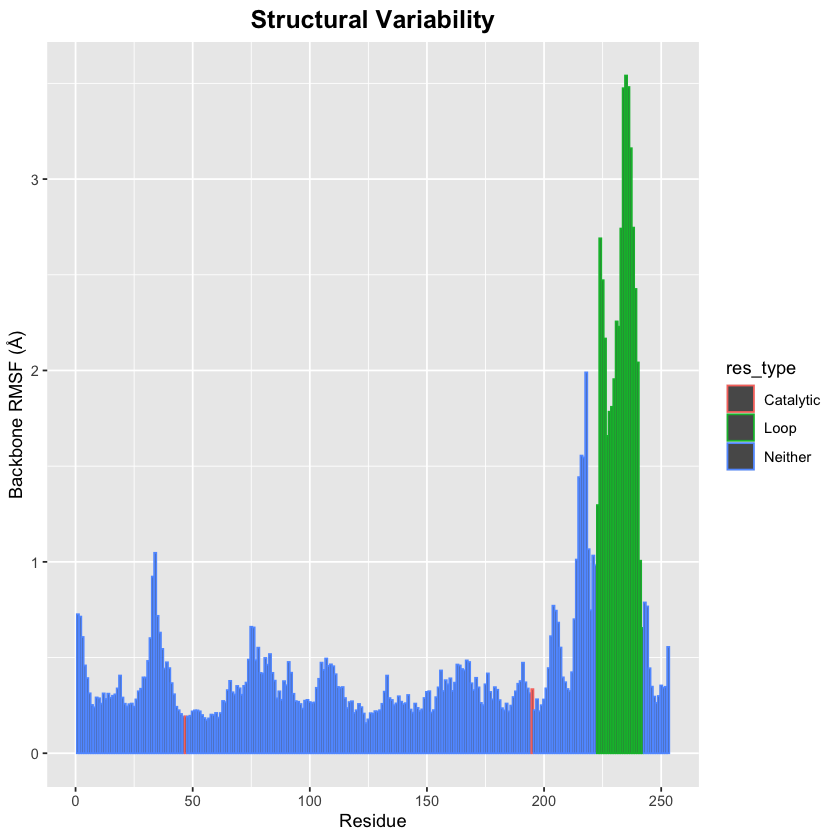

In [337]:
struc_df <- data.frame(res_type, res_inds = c(1:253), rmsf_vals)
    
ggplot(struc_df, aes(x = res_inds, y = rmsf_vals, color = res_type)) + geom_bar(stat="identity") + labs(title="Structural Variability", x ="Residue", y = "Backbone RMSF (Å)") + theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5)) #(24, 25)

**Figure 5.** Structural variability among the models of the NMR solution structure PDB 2JTC (3), as indicated by backbone (CA, C, N, and O atom) RMSF values. The residues of the C-terminal loop are indicated with green bars; catalytic residues have red bars and all other residues are indicated with blue bars.

### Part 3: Comparing Sequence Entropy and Structural Variability

The next code normalizes the RMSF values to a scale from 0 to 1, using the same function written above:

In [338]:
rmsf_norm <- normalize(rmsf_vals)

Then the following block creates a dataframe: The first column is again the residue type vector, the second contains the normalized RMSF values, and the third contains the normalized Shannon entropy values:

In [339]:
df <- data.frame(res_type, rmsf_norm, seqs_H_norm)

And the block below makes a scatter plot of the normalized sequence entropy versus the normalized RMSF values, distinguishing the points corresponding to the catalytic or C-terminal loop residues:

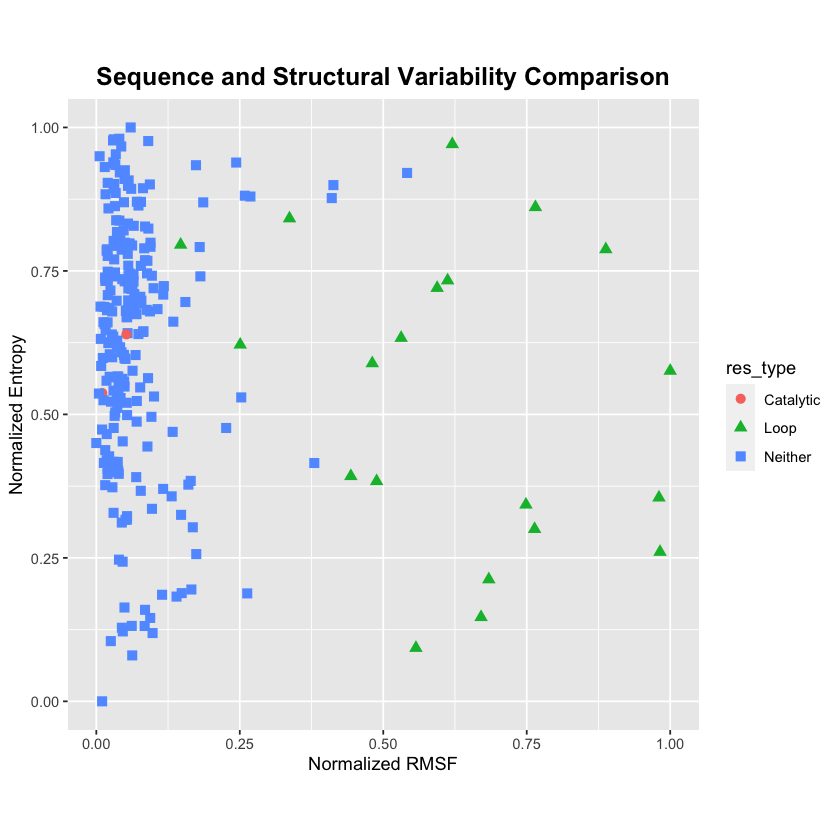

In [340]:
ggplot(df, aes(x = rmsf_norm, y = seqs_H_norm, color = res_type, shape = res_type)) + geom_point(size = 2.5) + labs(title="Sequence and Structural Variability Comparison", x ="Normalized RMSF", y = "Normalized Entropy") + theme(plot.title = element_text(size = 15, face = "bold", hjust = 0.5)) + coord_fixed() #(22, 23, 24)

**Figure 6.** Comparison of normalized sequence entropy and normalized structural variability for all residues in mature streptopain. The residues of the C-terminal loop are indicated with green triangles; the catalytic residues have red circles and all other residues are indicated with blue squares.

### Discussion

The normalized sequence entropy values calculated using 250 sequences (Figure 3) show that the C-terminal loop does indeed contain some low entropy positions, though other positions in the loop have high sequence variability. Given the functional significance of the loop, it makes sense that some of its residues would be conserved; Figure 3 supports this notion and offers a suggestion of which residues are the most conserved. Interestingly, both of the catalytic residues are near low-entropy regions but do not themselves have low entropy values.

The RMSF data also supports my hypothesis (Figure 5). As expected, the C-terminal loop is clearly in a highly flexible region, showing greater structural variability compared to most of the rest of the protein.

Figure 6 brings the two datasets together. With normalized structural variability on the x axis and normalized sequence variability on the y axis, my hypothesis is equivalent to saying that the loop residues will be far to the right and have some points near the bottom, which is largely true in the graph: All but one of the residues past 0.5 on the x axis are loop residues, and some of the lowest sequence variability values (lowest on the y axis) are indeed for loop residues.

The sequence entropy part of this project in particular suggests inquiries for future work: Why do the catalytic residues appear to not be especially conserved? And given that the Entrez search used here did not restrict results by species, how does sequence entropy within a species (*S. pyogenes*) compare with that obtained from considering multiple species? Furthermore, though caution must be taken to avoid including extraneous sequences, it would be interesting to explore how the number of streptopain sequences used affects the outcome.

### References

(1) González-Páez & Wolan. 2012. "Ultrahigh and High Resolution Structures and Mutational Analysis of Monomeric Streptococcus pyogenes SpeB Reveal a Functional Role for the Glycine-rich C-terminal Loop." JBC 287, 24412.

(2) Teilum et al. 2009. "Functional aspects of protein flexibility." Cellular and Molecular Life Sciences 66, 2231.

(3) Wang et al. 2009. "Solution Structure and Backbone Dynamics of Streptopain INSIGHT INTO DIVERSE SUBSTRATE SPECIFICITY." JBC 284, 10957.

(4) Olsen et al. 2009. "Structure of the Mature Streptococcal Cysteine Protease Exotoxin mSpeB in Its Active Dimeric Form." Journal of Molecular Biology 393, 693.

(5) Kagawa et al. 2000. "Crystal structure of the zymogen form of the group A Streptococcus virulence factor SpeB: An integrin-binding cysteine protease." PNAS 5, 2235.

(6) Pettersen et al. 2004. "UCSF Chimera--a visualization system for exploratory research and analysis." Journal of Computational Chemistry 13, 1605.

(11) Edgar. 2004. "MUSCLE: multiple sequence alignment with high accuracy and high throughput." Nucleic Acids Research 32, 1792.

#### Sources that informed my code:

(7) http://thegrantlab.org/bio3d/index.html    
(8) https://github.com/ropensci/rentrez      
(9) https://cran.r-project.org/web/packages/rentrez/vignettes/rentrez_tutorial.html   
(10) http://thegrantlab.org/bio3d/reference/read.fasta.html   
(12) https://www.drive5.com/muscle/downloads.htm   
(13) http://www.drive5.com/muscle/manual/install.html   
(14) http://thegrantlab.org/bio3d/reference/seqaln.html   
(15) http://thegrantlab.org/bio3d/reference/entropy.html   
(16) http://thegrantlab.org/bio3d/reference/rmsf.html   
(17) http://thegrantlab.org/bio3d/reference/read.pdb.html   
(18) https://stat.ethz.ch/pipermail/r-help/2006-February/088205.html   
(19) https://cran.r-project.org/web/packages/comprehenr/vignettes/Introduction.html   
(20) https://rdrr.io/cran/comprehenr/   
(21) https://datasharkie.com/how-to-normalize-data-in-r/   
(22) http://www.sthda.com/english/wiki/ggplot2-scatter-plots-quick-start-guide-r-software-and-data-visualization   
(23) https://stackoverflow.com/questions/7056836/how-to-fix-the-aspect-ratio-in-ggplot   
(24) http://www.sthda.com/english/wiki/ggplot2-title-main-axis-and-legend-titles   
(25) http://www.sthda.com/english/wiki/ggplot2-barplots-quick-start-guide-r-software-and-data-visualization   
(26) https://stackoverflow.com/questions/1169248/test-if-a-vector-contains-a-given-element   